## 1a. IMDB Tables

In [1]:
from wip_michael import *

/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/michaeleby1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2]:
df_movies[df_movies['tconst'] == 'tt0133093']

tconst       title  year runtime         genres  averageRating  \
89807  tt0133093  The Matrix  1999     136  Action,Sci-Fi            8.7   

        numVotes  
89807  1549437.0

In [3]:
df_movies[df_movies['title'] == 'Citizen Kane']

tconst         title  year runtime         genres  averageRating  \
22990  tt0033467  Citizen Kane  1941     119  Drama,Mystery            8.3   

       numVotes  
22990  370950.0

## 1b. Creating a Junction Table (linking names to movies)

In [32]:
import mysql.connector
import config
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.passwd
)

config.host
cursor = cnx.cursor()

In [34]:
from mysql.connector import errorcode

db_name = "microsoft"

def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

In [35]:
# Create a table for the IMDB data
DB_NAME = 'microsoft'

TABLES = {}
TABLES['imdb_movies'] = (
    "CREATE TABLE imdb_movies ("
    "  id varchar(255) NOT NULL UNIQUE PRIMARY KEY,"
    "  title varchar(255) NOT NULL,"
    "  year int NOT NULL,"
    "  runtime int NOT NULL,"
    "  genres varchar(255) NOT NULL,"
    "  rating float NOT NULL,"
    "  numVotes int NOT NULL"
    ") ENGINE=InnoDB")

# TABLES['imdb_names'] = (
#     "CREATE TABLE imdb_names ("
#     "  person_id varchar(255) NOT NULL PRIMARY KEY,"
#     "  name varchar(255) NOT NULL,"
#     "  birthYear int NOT NULL,"
#     "  profession varchar(255) NOT NULL,"
#     "  imdb_id varchar(255) NOT NULL,"
#     "  FOREIGN KEY (imdb_id) REFERENCES imdb_movies (imdb_id)"
#     ") ENGINE=InnoDB")

TABLES['junction'] = (
    "CREATE TABLE junction ("
    "  person_id varchar(255) NOT NULL,"
    "  imdb_id varchar(255) NOT NULL,"
    "  FOREIGN KEY (imdb_id) REFERENCES imdb_movies (id)"
    ") ENGINE=InnoDB")

In [36]:
from mysql.connector import errorcode

db_name = "microsoft"

for table_name in TABLES:
    table_description = TABLES[table_name]
    try:
        print("Creating table {}: ".format(table_name), end='')
        cursor.execute(table_description)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
            print("already exists.")
        else:
            print(err.msg)
    else:
        print("OK")

Creating table imdb_movies: already exists.
Creating table junction: already exists.


In [ ]:
movie_tuples = [tuple(x) for x in df_movies.values]
db_insert(movie_tuples)

In [ ]:
name_tuples = [tuple(x) for x in df_name.values]

name_tuples

In [25]:
df_name.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0050419,tt0053137,tt0043044,tt0072308  
1              actress,soundtrack  tt0037382,tt0071877,tt0038355,tt0117057  
2     actress,soundtrack,producer  tt0057345,tt0049189,tt0059956,tt0054452  
3         actor,writer,soundtrack  tt0080455,tt0078723,tt0077975,tt0072562  
4           writer,director,actor  tt0050986,tt0050976,tt0083922,tt0069467

In [37]:
for i, row in df_name.iterrows():
    actor = str(row['nconst'])
    print(actor)
    titles = str(row['knownForTitles']).split(',')
    print(titles)
    for title in titles:
        print(title)
        if title in list(df_movies['tconst'].values):
            insert_junction_table(actor, title)
        else:
            continue

nm0000001
['tt0050419', 'tt0053137', 'tt0043044', 'tt0072308']
tt0050419


IntegrityError: 1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`microsoft`.`junction`, CONSTRAINT `junction_ibfk_1` FOREIGN KEY (`imdb_id`) REFERENCES `imdb_movies` (`id`))

In [11]:
def insert_junction_table(actor, title):
    insert_query = """INSERT INTO microsoft.junction (person_id, imdb_id) VALUES (%s, %s);"""
    cursor.execute(insert_query, (actor, title))
    cnx.commit()

In [13]:
df_name['knownForTitles'][0].split(',')

['tt0050419', 'tt0053137', 'tt0043044', 'tt0072308']

In [264]:
len(df_name)

9665001

## 2. The Movie Database API

In [10]:
import json
import requests

api_key = '4f3f2d2aea79f403399bd52376f7aa1d' 

In [13]:
def themoviedb_call(api_key, imdb_id):
    url = f'https://api.themoviedb.org/3/find/{imdb_id}?api_key={api_key}&language=en-US&external_source=imdb_id'
    response = requests.get(url)
    data = response.json()['movie_results'][0]
    data['imdb_id'] = imdb_id
    return data

In [191]:
themoviedb_call(api_key, 'tt0068646')

{'id': 238,
 'video': False,
 'vote_count': 10799,
 'vote_average': 8.6,
 'title': 'The Godfather',
 'release_date': '1972-03-14',
 'original_language': 'en',
 'original_title': 'The Godfather',
 'genre_ids': [80, 18],
 'backdrop_path': '/6xKCYgH16UuwEGAyroLU6p8HLIn.jpg',
 'adult': False,
 'overview': 'Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.',
 'poster_path': '/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg',
 'popularity': 31.278,
 'imdb_id': 'tt0068646'}

## 3. Web-Scraping: Press for Films Currently Streaming

In [11]:
import requests
page = requests.get('https://web.archive.org/web/20190527114817/https://www.vulture.com/article/best-movies-amazon-prime.html')
page.status_code

200

In [14]:
page.content

b'  <!DOCTYPE html>\n<html lang="en" data-uri="www.vulture.com/_pages/cjtt84iyj003ma2y628qamili@published" data-layout-uri="www.vulture.com/_layouts/layout/instances/article@published">\n  <head><script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript"></script>\n<script type="text/javascript">window.addEventListener(\'DOMContentLoaded\',function(){var v=archive_analytics.values;v.service=\'wb\';v.server_name=\'wwwb-app13.us.archive.org\';v.server_ms=303;archive_analytics.send_pageview({});});</script><script type="text/javascript" src="/_static/js/ait-client-rewrite.js" charset="utf-8"></script>\n<script type="text/javascript">\nWB_wombat_Init("https://web.archive.org/web/", "20190527114817", "www.vulture.com");\n</script>\n<script type="text/javascript" src="/_static/js/wbhack.js" charset="utf-8"></script>\n<script type="text/javascript">\n__wbhack.init(\'https://web.archive.org/web\');\n</script>\n<link rel="stylesheet" type="text/css" href="/_static/css/ban

In [15]:
from bs4 import BeautifulSoup
vulture_may = BeautifulSoup(page.content, 'html.parser')
vulture_may

 <!DOCTYPE html>

<html data-layout-uri="www.vulture.com/_layouts/layout/instances/article@published" data-uri="www.vulture.com/_pages/cjtt84iyj003ma2y628qamili@published" lang="en">
<head><script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript"></script>
<script type="text/javascript">window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app13.us.archive.org';v.server_ms=303;archive_analytics.send_pageview({});});</script><script charset="utf-8" src="/_static/js/ait-client-rewrite.js" type="text/javascript"></script>
<script type="text/javascript">
WB_wombat_Init("https://web.archive.org/web/", "20190527114817", "www.vulture.com");
</script>
<script charset="utf-8" src="/_static/js/wbhack.js" type="text/javascript"></script>
<script type="text/javascript">
__wbhack.init('https://web.archive.org/web');
</script>
<link href="/_static/css/banner-styles.css" rel="stylesheet" type="text/css"/>
<link

In [16]:
print(vulture_may.prettify())

<!DOCTYPE html>
<html data-layout-uri="www.vulture.com/_layouts/layout/instances/article@published" data-uri="www.vulture.com/_pages/cjtt84iyj003ma2y628qamili@published" lang="en">
 <head>
  <script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript">
  </script>
  <script type="text/javascript">
   window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app13.us.archive.org';v.server_ms=303;archive_analytics.send_pageview({});});
  </script>
  <script charset="utf-8" src="/_static/js/ait-client-rewrite.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   WB_wombat_Init("https://web.archive.org/web/", "20190527114817", "www.vulture.com");
  </script>
  <script charset="utf-8" src="/_static/js/wbhack.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   __wbhack.init('https://web.archive.org/web');
  </script>
  <link href="/_static/css/banner-styles.css"

In [17]:
strong = vulture_may.find_all('strong')
strong

[<strong><em>12 Angry Men</em></strong>,
 <strong><em>*The 39 Steps</em></strong>,
 <strong>*<em>A.I.: Artificial Intelligence</em></strong>,
 <strong><em>The Accused</em></strong>,
 <strong><em>The Act of Killing</em></strong>,
 <strong><em>Annihilation</em></strong>,
 <strong><em>The Apartment</em></strong>,
 <strong>*<em>Big Night</em></strong>,
 <strong><em>The Big Sick</em></strong>,
 <strong><em>Blue</em> <em>Velvet</em></strong>,
 <strong><em>The Blues Brothers</em></strong>,
 <strong><em>*Bone Tomahawk</em></strong>,
 <strong><em>Charade</em></strong>,
 <strong><em>Child’s Play</em></strong>,
 <strong><em>*Chinatown</em></strong>,
 <strong><em>*Cloverfield</em></strong>,
 <strong><em>Coherence</em></strong>,
 <strong><em>Cold War</em></strong>,
 <strong><em>The Conversation</em></strong>,
 <strong><em>Dead Ringers</em></strong>,
 <strong><em>The Dead Zone</em></strong>,
 <strong><em>Dear Zachary: A Letter to a Son About His Father</em></strong>,
 <strong><em>Deep Red</em></stro

In [18]:
titles = []
for i in list(range(len(strong))):
    titles.append(strong[i].get_text())
titles

['12 Angry Men',
 '*The 39 Steps',
 '*A.I.: Artificial Intelligence',
 'The Accused',
 'The Act of Killing',
 'Annihilation',
 'The Apartment',
 '*Big Night',
 'The Big Sick',
 'Blue Velvet',
 'The Blues Brothers',
 '*Bone Tomahawk',
 'Charade',
 'Child’s Play',
 '*Chinatown',
 '*Cloverfield',
 'Coherence',
 'Cold War',
 'The Conversation',
 'Dead Ringers',
 'The Dead Zone',
 'Dear Zachary: A Letter to a Son About His Father',
 'Deep Red',
 'Diabolique',
 '*The Disaster Artist',
 'Dressed to Kill',
 'Eighth Grade',
 '*Fargo',
 'First Reformed',
 'A Fistful of Dollars',
 'Fitzcarraldo',
 'The Florida Project',
 'Gangs of New York',
 'A Ghost Story',
 'Good Time',
 'The Handmaiden',
 'Heathers',
 'Henry: Portrait of a Serial Killer',
 'Hereditary',
 'High Noon',
 '*His Girl Friday',
 'Hoop Dreams',
 'Hotel Rwanda',
 'House of Games',
 'Hugo',
 'Hustle & Flow',
 'Inside Llewyn Davis',
 'Interview With the Vampire',
 'Invasion of the Body Snatchers',
 'It’s a Wonderful Life',
 'Joe',
 '*Th

In [19]:
page2 = requests.get('https://web.archive.org/web/20190330083826/https://www.vulture.com/article/best-movies-amazon-prime.html')
page2.status_code

200

In [20]:
vulture_march = BeautifulSoup(page2.content, 'html.parser')
print(vulture_march.prettify())

<!DOCTYPE html>
<html data-layout-uri="www.vulture.com/_layouts/layout/instances/article@published" data-uri="www.vulture.com/_pages/cjtt84iyj003ma2y628qamili@published" lang="en">
 <head>
  <script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript">
  </script>
  <script type="text/javascript">
   window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app43.us.archive.org';v.server_ms=397;archive_analytics.send_pageview({});});
  </script>
  <script charset="utf-8" src="/_static/js/ait-client-rewrite.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   WB_wombat_Init("https://web.archive.org/web/", "20190330083826", "www.vulture.com");
  </script>
  <script charset="utf-8" src="/_static/js/wbhack.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   __wbhack.init('https://web.archive.org/web');
  </script>
  <link href="/_static/css/banner-styles.css"

In [21]:
strong2 = vulture_march.find_all('strong')
strong2

[<strong><em>12 Angry Men</em></strong>,
 <strong><em>The Act of Killing</em></strong>,
 <strong><em>American Honey</em></strong>,
 <strong><em>Annihilation</em></strong>,
 <strong><em>The Apartment</em></strong>,
 <strong><em>Arrival</em></strong>,
 <strong><em>The Big Sick</em></strong>,
 <strong><em>Bill &amp; Ted’s Excellent Adventure</em></strong>,
 <strong><em>The Birdcage</em></strong>,
 <strong><em>The Blackcoat’s Daughter</em></strong>,
 <strong><em>Blue</em> <em>Velvet</em></strong>,
 <strong><em>The Blues Brothers</em></strong>,
 <strong><em>Bound</em></strong>,
 <strong><em>Brazil</em></strong>,
 <strong><em>Capote</em></strong>,
 <strong><em>Charade</em></strong>,
 <strong><em>Child’s Play</em></strong>,
 <strong><em>Chinatown</em></strong>,
 <strong><em>Coherence</em></strong>,
 <strong><em>Cold War</em></strong>,
 <strong><em>The Conversation</em></strong>,
 <strong><em>Dead Ringers</em></strong>,
 <strong><em>Dear Zachary: A Letter to a Son About His Father</em></strong

In [22]:
for i in list(range(len(strong2))):
    titles.append(strong2[i].get_text())
titles

['12 Angry Men',
 '*The 39 Steps',
 '*A.I.: Artificial Intelligence',
 'The Accused',
 'The Act of Killing',
 'Annihilation',
 'The Apartment',
 '*Big Night',
 'The Big Sick',
 'Blue Velvet',
 'The Blues Brothers',
 '*Bone Tomahawk',
 'Charade',
 'Child’s Play',
 '*Chinatown',
 '*Cloverfield',
 'Coherence',
 'Cold War',
 'The Conversation',
 'Dead Ringers',
 'The Dead Zone',
 'Dear Zachary: A Letter to a Son About His Father',
 'Deep Red',
 'Diabolique',
 '*The Disaster Artist',
 'Dressed to Kill',
 'Eighth Grade',
 '*Fargo',
 'First Reformed',
 'A Fistful of Dollars',
 'Fitzcarraldo',
 'The Florida Project',
 'Gangs of New York',
 'A Ghost Story',
 'Good Time',
 'The Handmaiden',
 'Heathers',
 'Henry: Portrait of a Serial Killer',
 'Hereditary',
 'High Noon',
 '*His Girl Friday',
 'Hoop Dreams',
 'Hotel Rwanda',
 'House of Games',
 'Hugo',
 'Hustle & Flow',
 'Inside Llewyn Davis',
 'Interview With the Vampire',
 'Invasion of the Body Snatchers',
 'It’s a Wonderful Life',
 'Joe',
 '*Th

In [23]:
titles = set(titles)
titles = list(titles)

In [24]:
type(titles)
titles

['Some Like It Hot',
 'The Accused',
 '*A Quiet Place',
 'Cold War',
 'Joe',
 'Now',
 'The Thomas Crown Affair',
 'The Big Sick',
 'Arrival',
 'Hustle & Flow',
 'Gangs of New York',
 'Shutter Island',
 '*Cloverfield',
 'Interview With the Vampire',
 'Chinatown',
 'Capote',
 'Brazil',
 '*The 39 Steps',
 'Blue Velvet',
 '*Leaving Las Vegas',
 'Bound',
 'The Purple Rose of Cairo',
 'A Fistful of Dollars',
 'Sophie’s Choice',
 'The Terminator',
 'The Dead Zone',
 'House of Games',
 'Witness',
 'Fitzcarraldo',
 'Annihilation',
 'Moonstruck',
 'Up in the Air',
 'Coherence',
 'Leave No Trace',
 '*Murder on the Orient Express',
 'The Lost City of Z',
 '*Wanderlust',
 '12 Angry Men',
 'We Are Still Here',
 'Paths of Glory',
 'Star Trek',
 'Total Recall',
 'Mud',
 'The Conversation',
 '*Chinatown',
 '*Big Night',
 'The Act of Killing',
 'Hugo',
 'Thelma and Louise',
 'Moonlight',
 'Thunder Road',
 'The Virgin Suicides',
 'The Proposition',
 'The Blackcoat’s Daughter',
 'Dirty Rotten Scoundrels',

In [31]:
len(titles)

131

In [44]:
# I got this from Matt

afi = ['A Space Odyssey',
 'Angry Men',
 'A Clockwork Orange',
 'A Night At The Opera',
 'A Streetcar Named Desire',
 'All About Eve',
 'All The Presidents Men',
 'American Graffiti',
 'Annie Hall',
 'Apocalypse Now',
 'Benhur',
 'Blade Runner',
 'Bonnie And Clyde',
 'Bringing Up Baby',
 'Butch Cassidy And The Sundance Kid',
 'Cabaret',
 'Casablanca',
 'Chinatown',
 'Citizen Kane',
 'City Lights',
 'Do The Right Thing',
 'Double Indemnity',
 'Dr Strangelove Or How I Learned To Stop Worrying And Love The Bomb',
 'Duck Soup',
 'Easy Rider',
 'Et  The Extraterrestrial',
 'Forrest Gump',
 'Gone With The Wind',
 'Goodfellas',
 'High Noon',
 'In The Heat Of The Night',
 'Intolerance',
 'It Happened One Night',
 'Its A Wonderful Life',
 'Jaws',
 'King Kong',
 'Lawrence Of Arabia',
 'Mash',
 'Midnight Cowboy',
 'Modern Times',
 'Mr Smith Goes To Washington',
 'Nashville',
 'Network',
 'North By Northwest',
 'On The Waterfront',
 'One Flew Over The Cuckoos Nest',
 'Platoon',
 'Psycho',
 'Pulp Fiction',
 'Raging Bull',
 'Raiders Of The Lost Ark',
 'Rear Window',
 'Rocky',
 'Saving Private Ryan',
 'Schindlers List',
 'Shane',
 'Singin In The Rain',
 'Snow White And The Seven Dwarfs',
 'Some Like It Hot',
 'Sophies Choice',
 'Spartacus',
 'Star Wars',
 'Sullivans Travels',
 'Sunrise  A Song Of Two Humans',
 'Sunset Blvd',
 'Swing Time',
 'Taxi Driver',
 'The African Queen',
 'The Apartment',
 'The Best Years Of Our Lives',
 'The Bridge On The River Kwai',
 'The Deer Hunter',
 'The French Connection',
 'The General',
 'The Godfather',
 'The Godfather Part Ii',
 'The Gold Rush',
 'The Graduate',
 'The Grapes Of Wrath',
 'The Last Picture Show',
 'The Lord Of The Rings The Fellowship Of The Ring',
 'The Maltese Falcon',
 'The Philadelphia Story',
 'The Searchers',
 'The Shawshank Redemption',
 'The Silence Of The Lambs',
 'The Sixth Sense',
 'The Sound Of Music',
 'The Treasure Of The Sierra Madre',
 'The Wild Bunch',
 'The Wizard Of Oz',
 'Titanic',
 'To Kill A Mockingbird',
 'Tootsie',
 'Toy Story',
 'Unforgiven',
 'Vertigo',
 'West Side Story',
 'Whos Afraid Of Virginia Woolf',
 'Yankee Doodle Dandy',
 'A Quiet Place',
 'A Simple Plan',
 'A.I.: Artificial Intelligence',
 'Big Night',
 'Bone Tomahawk',
 'Chinatown',
 'Cloverfield',
 'Election',
 'Fargo',
 'Gloria Bell',
 'Good Time',
 'Hard Eight',
 'His Girl Friday',
 'Hoosiers',
 'King Of New York',
 'Leaving Las Vegas',
 'Mission: Impossible – Fallout',
 'Murder On The Orient Express',
 'Nobody’S Fool',
 'Philadelphia',
 'Side Effects',
 'Sunset Boulevard',
 'The 39 Steps',
 'The Apartment',
 'The Birdcage',
 'The Dark Crystal',
 'The Disaster Artist',
 'The Fifth Element',
 'The Killing',
 'The King Of Comedy',
 'The Limey',
 'The Virgin Suicides',
 'To Kill A Mockingbird',
 'Under The Silver Lake',
 'Wanderlust',
 'Zodiac',
 '12 Angry Men',
 '12 Monkeys',
 'A Fish Called Wanda',
 'A Fistful Of Dollars',
 'A Ghost Story',
 'A Quiet Place',
 'A Shot In The Dark',
 'A Simple Plan',
 'Aguirre, The Wrath Of God',
 'American Honey',
 'Annihilation',
 'Arrival',
 'Big Night',
 'Bill & Ted’S Excellent Adventure',
 'Blow Out',
 'Blue Velvet',
 'Bound',
 'Brazil',
 'Bringing Out The Dead',
 'Capote',
 'Carrie',
 'Charade',
 'Children Of A Lesser God',
 'Child’S Play',
 'Chinatown',
 'Cloverfield',
 'Coherence',
 'Cold War',
 'Dead Ringers',
 'Dear Zachary: A Letter To A Son About His Father',
 'Deep Red',
 'Diabolique',
 'Dirty Rotten Scoundrels',
 'District 9',
 'Donnie Darko',
 'Dressed To Kill',
 'Eighth Grade',
 'First Reformed',
 'Fitzcarraldo',
 'Gangs Of New York',
 'Get Shorty',
 'Goldeneye',
 'Good Time',
 'Grizzly Man',
 'Heathers',
 'Henry: Portrait Of A Serial Killer',
 'Hereditary',
 'High Noon',
 'His Girl Friday',
 'Hoop Dreams',
 'Hotel Rwanda',
 'House Of Games',
 'Hugo',
 'Hustle & Flow',
 'In The Heat Of The Night',
 'Inside Llewyn Davis',
 'Interview With The Vampire',
 'Invasion Of The Body Snatchers',
 'It’S A Wonderful Life',
 'Joe',
 'Lady Bird',
 'Last House On The Left',
 'Lean On Pete',
 'Leave No Trace',
 'Leaving Las Vegas',
 'Manchester By The Sea',
 'Marathon Man',
 'Memories Of Murder',
 'Midnight Cowboy',
 'Moonlight',
 'Moonstruck',
 'Mother!',
 'Mud',
 'Murder On The Orient Express',
 'Now',
 'Paradise Lost: The Child Murders At Robin Hood Hills',
 'Paterson',
 'Paths Of Glory',
 'Platoon',
 'Pride',
 'Raging Bull',
 'Rain Man',
 'Ronin',
 'Rosemary’S Baby',
 'Shivers',
 'Shutter Island',
 'Silence',
 'Some Like It Hot',
 'Something Wild',
 'Sophie’S Choice',
 'Spotlight',
 'Star Trek',
 'Star Trek Ii: The Wrath Of Khan',
 'Starship Troopers',
 'Stop Making Sense',
 'Stories We Tell',
 'The 39 Steps',
 'The Accused',
 'The Act Of Killing',
 'The African Queen',
 'The Apartment',
 'The Big Sick',
 'The Birdcage',
 'The Blackcoat’S Daughter',
 'The Blues Brothers',
 'The Conversation',
 'The Dead Zone',
 'The Florida Project',
 'The Handmaiden',
 'The Limey',
 'The Lost City Of Z',
 'The Machinist',
 'The Manchurian Candidate',
 'The Matrix',
 'The Messenger',
 'The Neon Demon',
 'The Proposition',
 'The Purple Rose Of Cairo',
 'The Running Man',
 'The Shootist',
 'The Squid And The Whale',
 'The Sweet Hereafter',
 'The Terminator',
 'The Thomas Crown Affair',
 'The Virgin Suicides',
 'Thelma & Louise',
 'Thelma And Louise',
 'Thunder Road',
 'Total Recall',
 'Transsiberian',
 'Up In The Air',
 'Wayne’s World',
 'We Are Still Here',
 'West Side Story',
 'Whale Rider',
 'Witness',
 'Wonder Boys',
 'You Were Never Really Here',
 'Zodiac']

In [46]:
# na_dict = {'afi': 1}
df_movies['top_movies'] = (df_movies['title'].isin(afi))
df_top = df_movies[df_movies['top_movies'] == True]

na_dict = {'\\N': np.nan}
df_top = df_top.dropna(subset=['numVotes'])

df_top['year'] = pd.to_numeric(df_top['year'])
df_top.describe()

year  averageRating      numVotes
count   311.000000     311.000000  3.110000e+02
mean   1986.289389       7.039228  1.390782e+05
std      26.657805       1.201479  2.796368e+05
min    1913.000000       2.000000  5.000000e+00
25%    1969.000000       6.600000  2.300000e+02
50%    1994.000000       7.300000  3.863000e+04
75%    2009.000000       7.900000  1.269130e+05
max    2019.000000       9.300000  2.153177e+06

In [47]:
df_suggestions = df_movies[(df_movies['year'] > 1999) & (df_movies['averageRating'] >= 7.7) & (df_movies['averageRating'] <= 8.2)
         & (df_movies['numVotes'] > 1000) & (df_movies['numVotes'] >= 37746) & (df_movies['numVotes'] <= 244166)]

In [36]:
df_top.describe()

year  averageRating      numVotes
count   311.000000     311.000000  3.110000e+02
mean   1986.289389       7.039228  1.390782e+05
std      26.657805       1.201479  2.796368e+05
min    1913.000000       2.000000  5.000000e+00
25%    1969.000000       6.600000  2.300000e+02
50%    1994.000000       7.300000  3.863000e+04
75%    2009.000000       7.900000  1.269130e+05
max    2019.000000       9.300000  2.153177e+06

## 4. Visualizations 

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


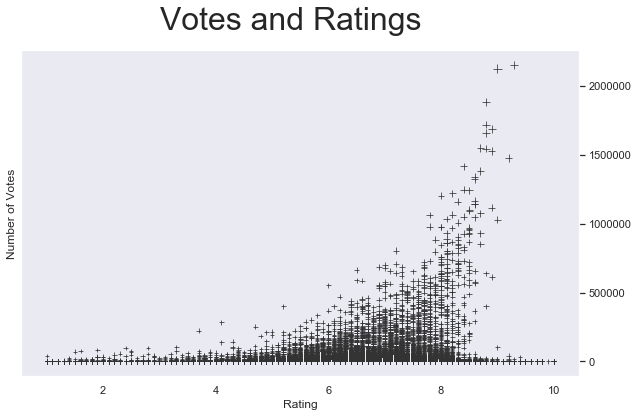

In [130]:

sns.set(style="dark")
f, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot('averageRating', 'numVotes', size='numVotes', data=df_movies, legend=None, color='.2', marker="+", ax=ax)
ax.set(xlabel='Rating', ylabel='Number of Votes')
f.suptitle('Votes and Ratings', ha='center', fontsize=32)
ax.yaxis.tick_right()

# ax.yaxis.set_label_position("right")


[(0, 10), Text(0.5, 0, '')]

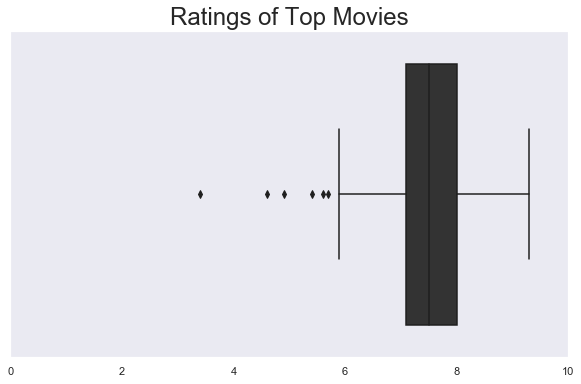

In [257]:
## 2nd chart: box plot displaying top films x review

f, ax = plt.subplots(figsize=(10,6))
sns.boxplot('averageRating', data=df_top, color='.2').set_title('Ratings of Top Movies', fontsize=24)
ax.set(xlabel='', xlim=(0, 10))




In [ ]:
## 4th chart: list of attractive movies currently unavailable through a subscription-based streaming service 